In [41]:
from example import authorization_code_grant, utils, request_surge_ride
from example.utils import import_oauth2_credentials
from uber_rides.session import Session, OAuth2Credential
from uber_rides.client import UberRidesClient

from geopy.geocoders import Nominatim
import requests


import csv
import pytz
import datetime
import geopy

TZ = pytz.timezone('Europe/Paris')

ADRESSES_DICT = {
    'home': '83, avenue de Ségur, 75015 Paris',
    'office': '43 Quai du Président Roosevelt, 92130 Issy-les-Moulineaux',
    'charles_de_gaulle_airport': '95700 Roissy-en-France',
    'eiffel_tower': '5 Avenue Anatole France, 75007 Paris',
    'gare_du_nord': '18 Rue de Dunkerque, 75010 Paris',
    'la_defense': '2 Place de la Défense, 92800 Puteaux',
    'montparnasse_tower': '33 Avenue du Maine, 75015 Paris',
}


geolocator = Nominatim()

address_location_dict = {key: geolocator.geocode(value) for (key, value) in ADRESSES_DICT.items()}

In [42]:
credentials = import_oauth2_credentials()
oauth2_credential = OAuth2Credential(**credentials)
new_session = Session(oauth2credential=oauth2_credential)

In [43]:
new_client = UberRidesClient(new_session)

In [44]:
response = new_client.get_products(address_location_dict['home'].latitude, address_location_dict['home'].longitude)
products = response.json.get('products')

In [45]:
for product in products:
    if product['display_name'] == 'uberX':
        product_id = product['product_id']

In [46]:
product_id

'5b451799-a7c3-480e-8720-891f2b51abb4'

In [47]:
new_client.estimate_ride(
    product_id=product_id,
    start_latitude=address_location_dict['home'].latitude,
    start_longitude=address_location_dict['home'].longitude,
    end_latitude=address_location_dict['office'].latitude,
    end_longitude=address_location_dict['office'].longitude,
).json

{'pickup_estimate': 3,
 'price': {'currency_code': 'EUR',
  'display': '7-10\xa0€',
  'fare_breakdown': [{'display_amount': '2.26-3.02',
    'display_name': 'Temps',
    'high_amount': 3.02,
    'low_amount': 2.26},
   {'display_amount': '3.94-5.26',
    'display_name': 'Distance',
    'high_amount': 5.26,
    'low_amount': 3.94},
   {'display_amount': '1.00',
    'display_name': 'Prix de base',
    'high_amount': 1.0,
    'low_amount': 1.0}],
  'high_estimate': 10,
  'low_estimate': 7,
  'minimum': 5,
  'surge_confirmation_href': None,
  'surge_confirmation_id': None,
  'surge_multiplier': 1.0},
 'trip': {'distance_estimate': 2.72,
  'distance_unit': 'mile',
  'duration_estimate': 600}}

In [48]:
now = TZ.localize(datetime.datetime.now())

In [53]:
combinations = (
    ('home', 'office'), 
    ('home', 'charles_de_gaulle_airport'), 
    ('eiffel_tower', 'gare_du_nord'), 
    ('la_defense', 'montparnasse_tower')
)


conversion_factor = 1.60934

with open('uber_monitoring.csv', 'a') as f:
    for combination in combinations:
        writer = csv.writer(f)
        
        from_place = combination[0]
        from_latitude = address_location_dict[from_place].latitude
        from_longitude = address_location_dict[from_place].longitude
        to_place = combination[1]
        to_latitude = address_location_dict[to_place].latitude
        to_longitude = address_location_dict[to_place].longitude
        
        now = TZ.localize(datetime.datetime.now())
        
        estimated_ride = new_client.estimate_ride(
            product_id=product_id,
            start_latitude=from_latitude,
            start_longitude=from_longitude,
            end_latitude=to_latitude,
            end_longitude=to_longitude,
        ).json
        
        row = [
            now,
            from_place,
            from_latitude,
            from_longitude,
            to_place,
            to_latitude,
            to_longitude,
            estimated_ride['trip']['distance_estimate'] * conversion_factor if estimated_ride['trip']['distance_unit'] == 'mile' else estimated_ride['trip']['distance_estimate'], 
            estimated_ride['trip']['duration_estimate'],
            estimated_ride['price']['surge_multiplier'],
            estimated_ride['price']['low_estimate'],
            estimated_ride['price']['high_estimate'],
        ]
        
        writer.writerow(row)                

In [7]:
%matplotlib inline

In [14]:
import pandas as pd
df = pd.read_csv('uber_monitoring.csv')

In [19]:
df['to_place'][0]

'office'

In [15]:
filtered_df = df[(df['from_place'] == 'home') & (df['to_place'] == 'office')]

(0, 30)

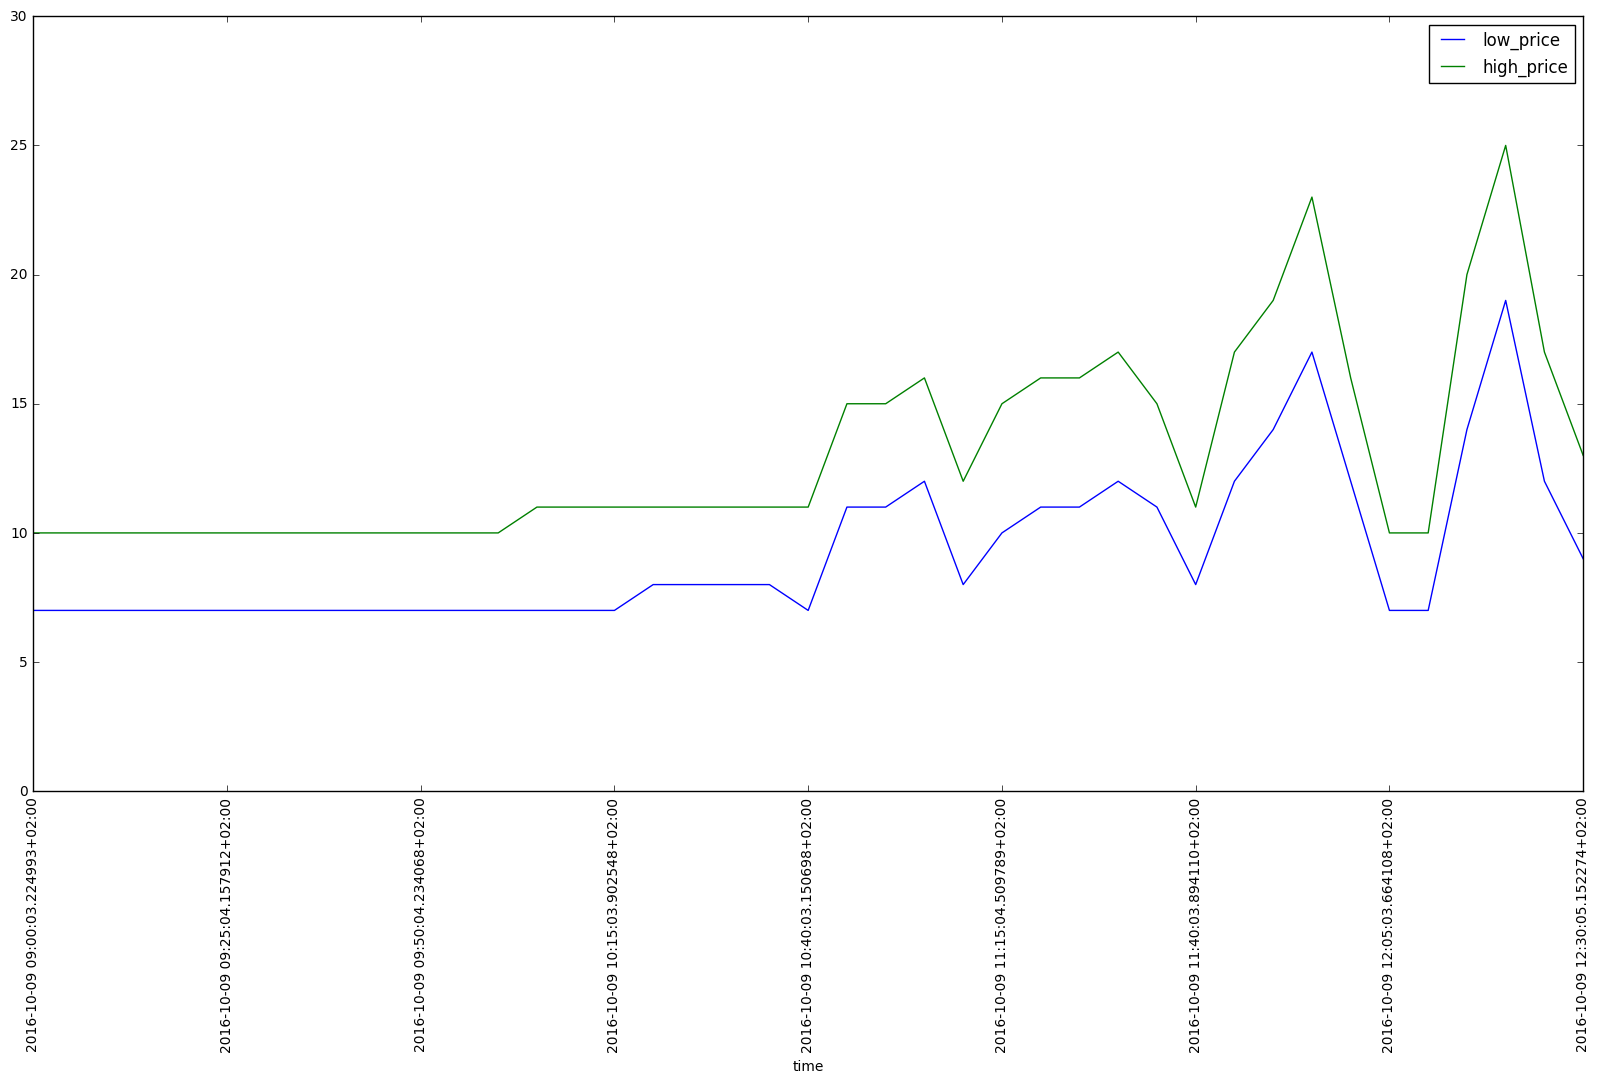

In [16]:
ax = filtered_df.plot(x='time', y=['low_price', 'high_price'], figsize=(20, 10), rot=90)
ax.set_ylim(0, 30)


In [60]:
def generate_filtered_csvs(address_combinations):
    df = pd.read_csv('uber_monitoring.csv')
    for combination in address_combinations:
        from_place = combination[0]
        to_place = combination[1]
        filtered_df = df[(df['from_place'] == from_place) & (df['to_place'] == to_place)]
        print(from_place, to_place)
        print('Will plot')
        ax = filtered_df.plot(x='time', y=['low_price', 'high_price'], figsize=(20, 10), rot=90)
        ax.set_ylim(0, 30)
        print('plotted')

home office
Will plot
plotted
home charles_de_gaulle_airport
Will plot
plotted
eiffel_tower gare_du_nord
Will plot
plotted
la_defense montparnasse_tower
Will plot
plotted


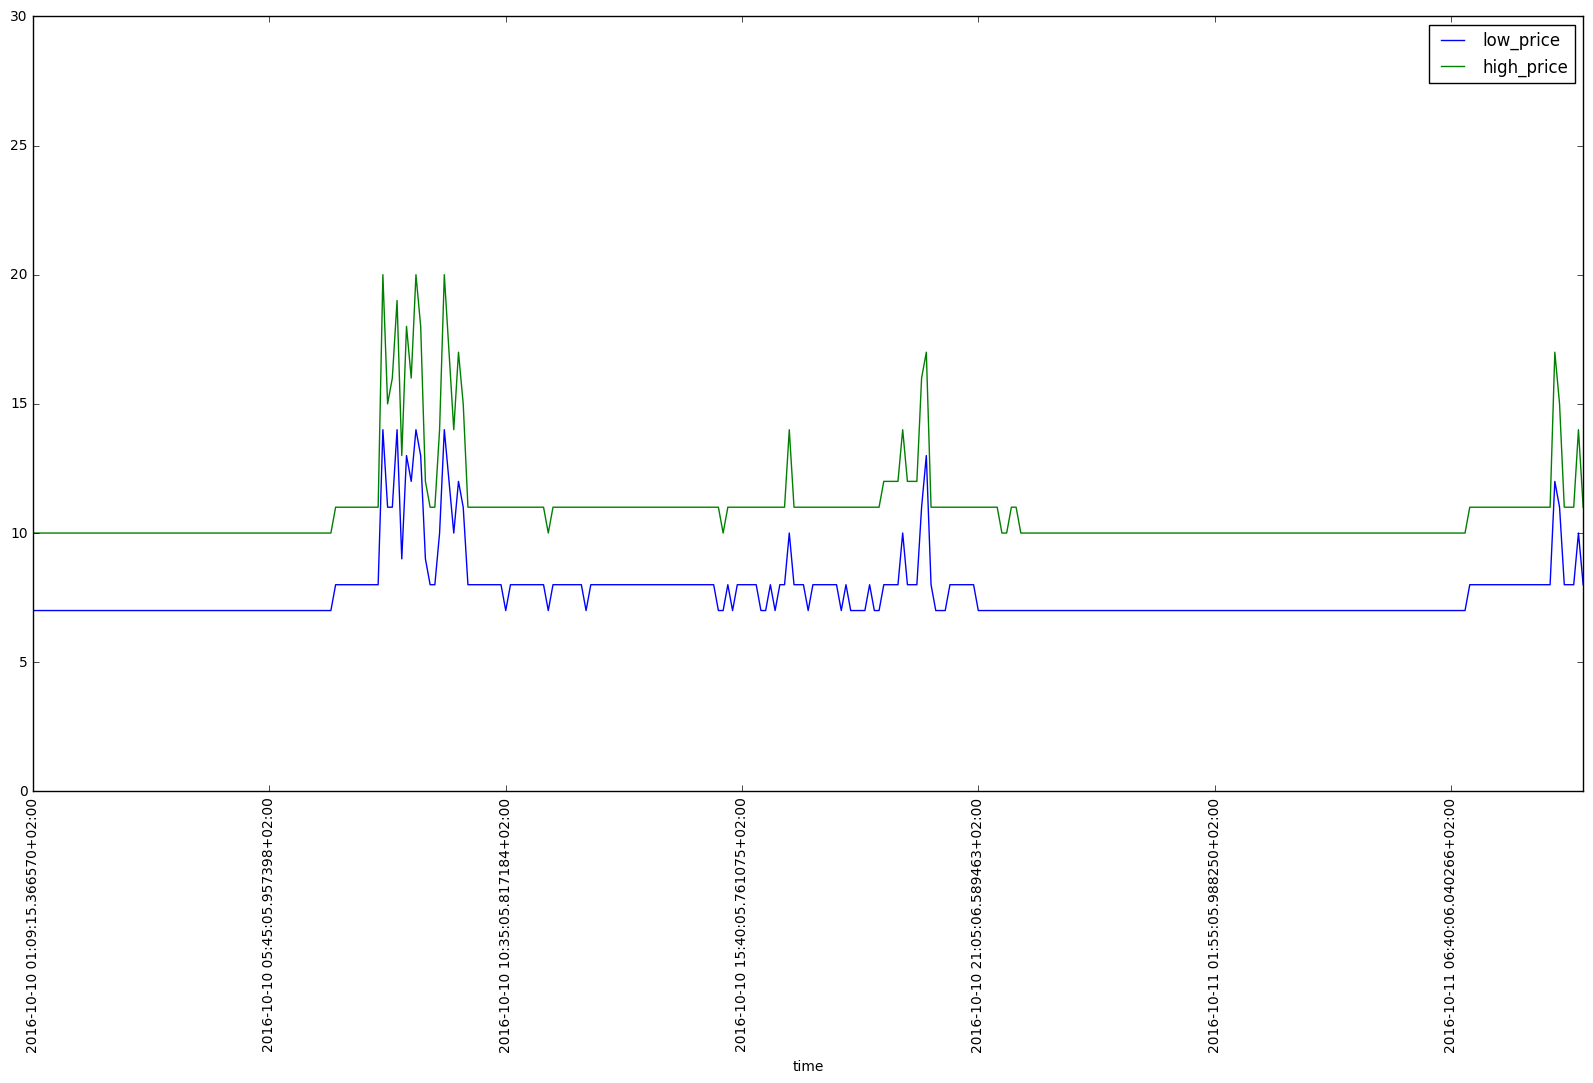

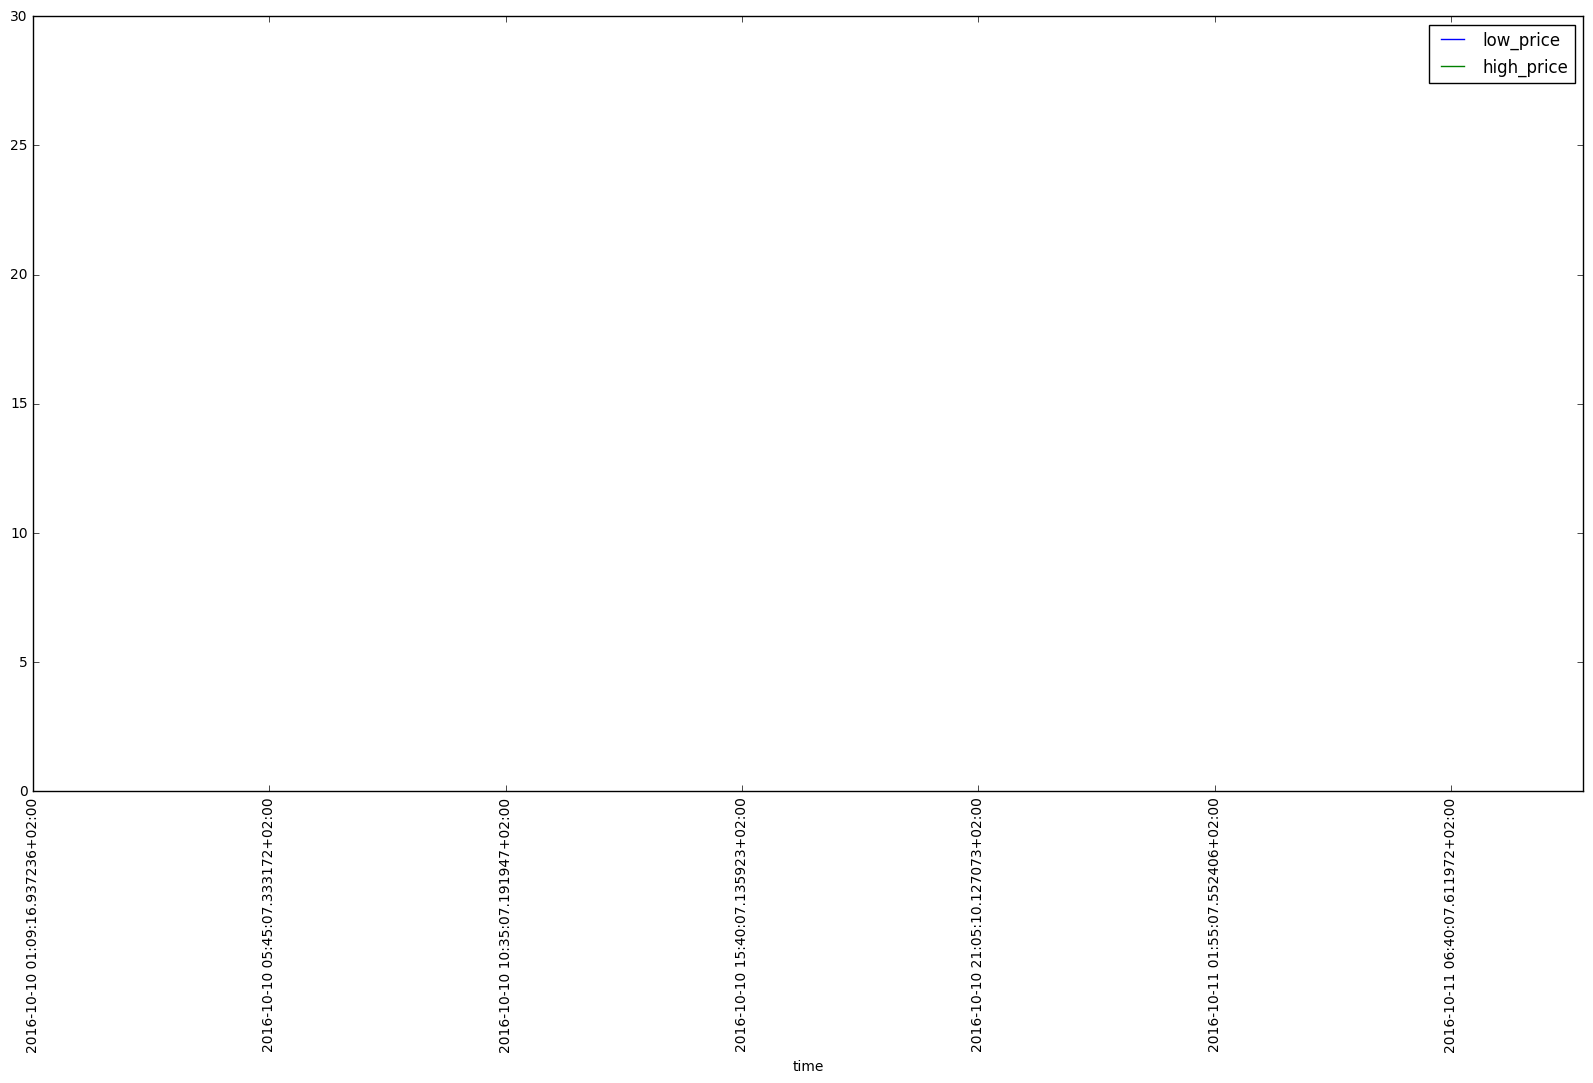

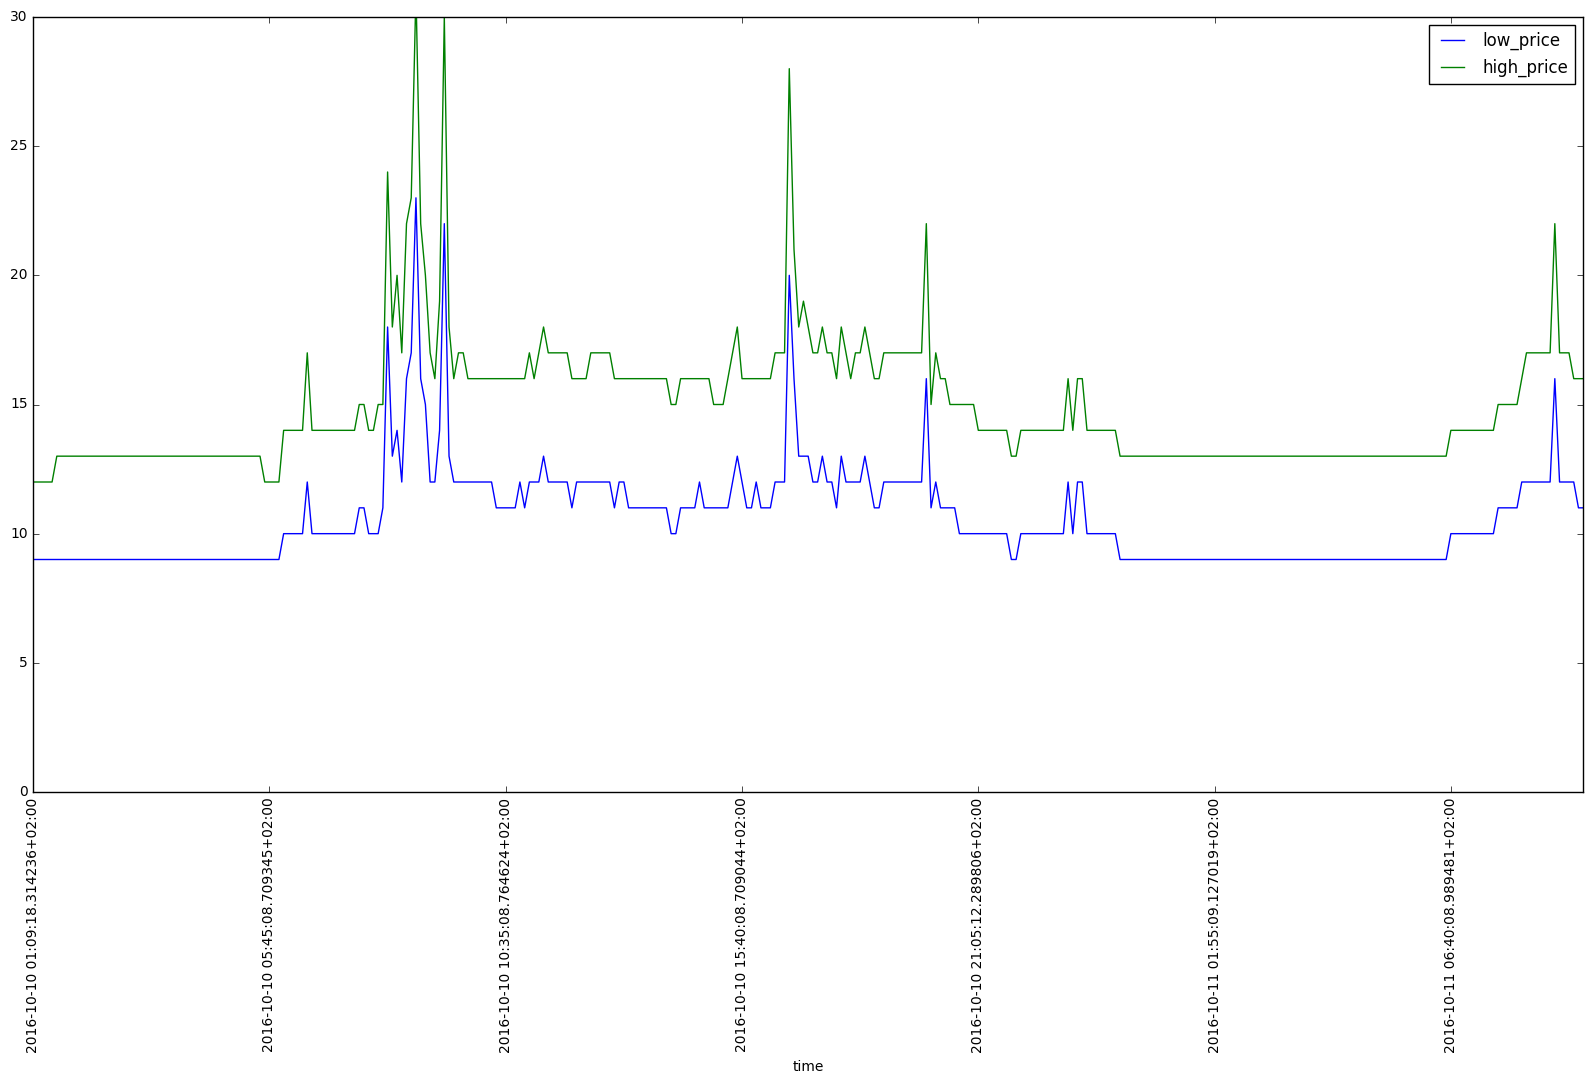

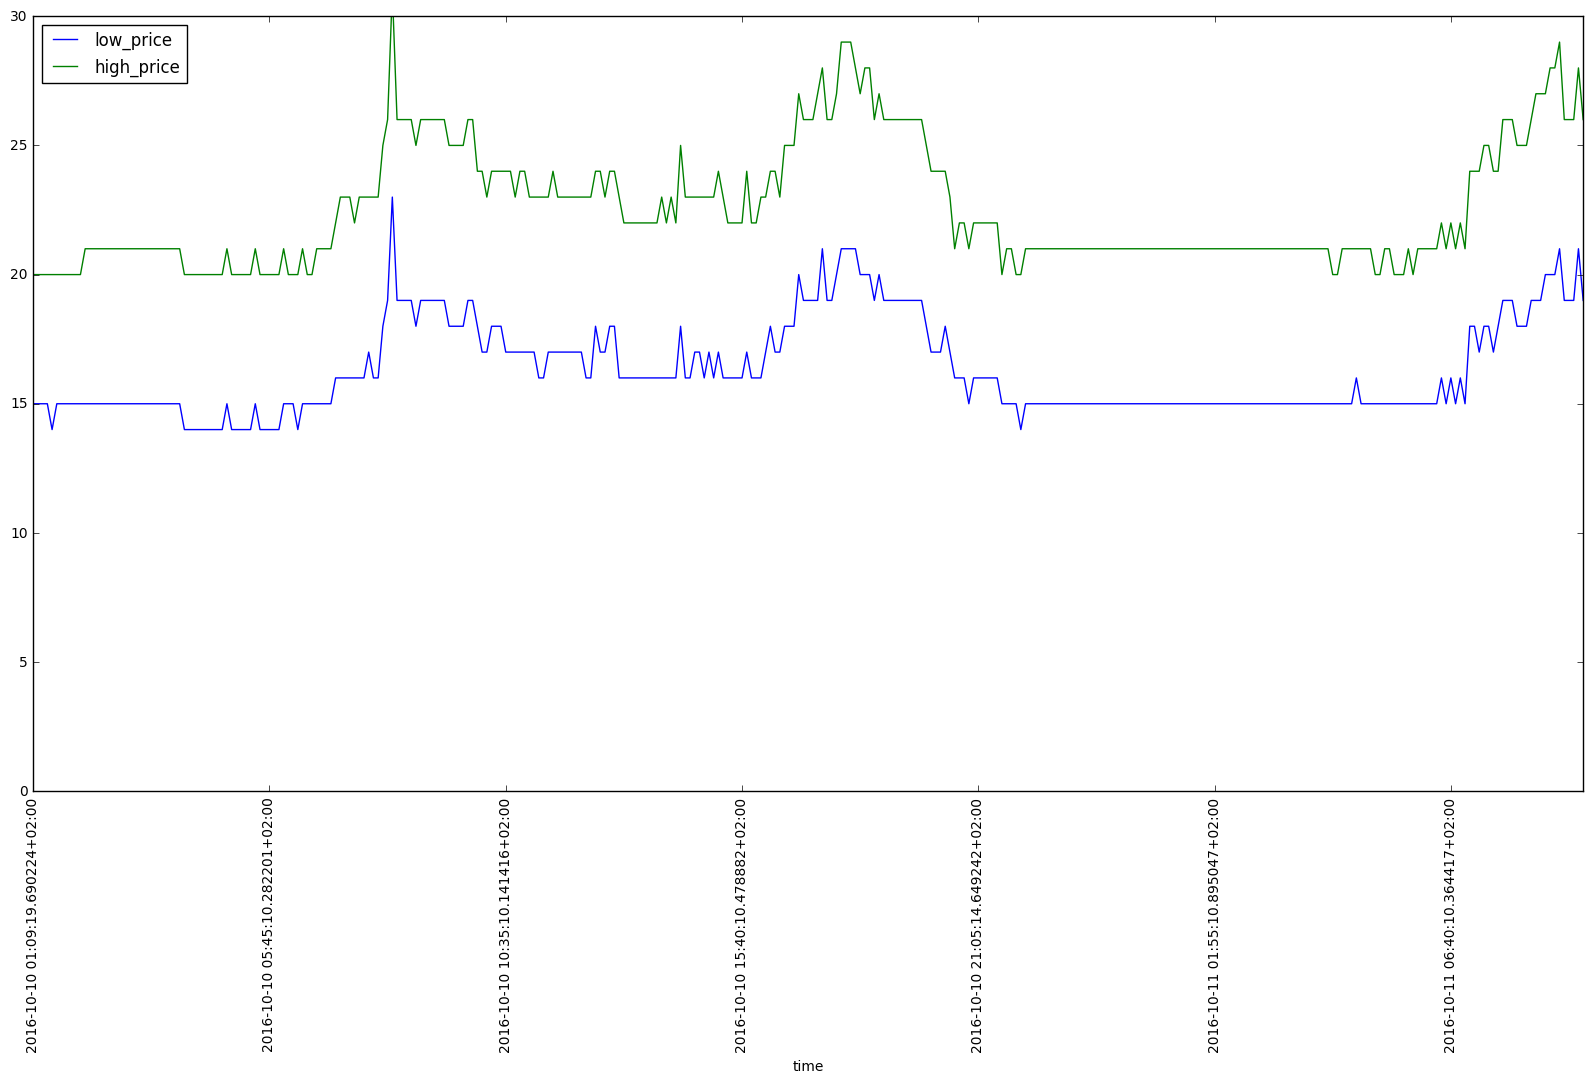

In [96]:
ADDRESS_COMBINATIONS = (
    ('home', 'office'),
    ('home', 'charles_de_gaulle_airport'),
    ('eiffel_tower', 'gare_du_nord'),
    ('la_defense', 'montparnasse_tower')
)
generate_filtered_csvs(ADDRESS_COMBINATIONS)

In [56]:
df = pd.read_csv('uber_monitoring.csv')
for combination in ADDRESS_COMBINATIONS:
    from_place = combination[0]
    to_place = combination[0]
    filtered_df = df[(df['from_place'] == from_place) & (df['to_place'] == to_place)]
    ax = filtered_df.plot(x='time', y=['low_price', 'high_price'], figsize=(20, 10), rot=90)
    ax.set_ylim(0, 30)
    print('plotted')

TypeError: Empty 'DataFrame': no numeric data to plot

In [68]:
df = pd.read_csv('uber_monitoring.csv')

In [59]:
df

,time,from_place,from_latitude,from_longitude,to_place,to_latitude,to_longitude,distance_estimate,duration_estimate,surge_multiplier,low_price,high_price
0,2016-10-10 01:09:15.366570+02:00,home,48.847098,2.305335,office,48.832854,2.263619,4.634899,540,1.0,7,10
1,2016-10-10 01:09:16.937236+02:00,home,48.847098,2.305335,charles_de_gaulle_airport,49.002529,2.514152,30.690114,2040,1.0,36,49
2,2016-10-10 01:09:18.314236+02:00,eiffel_tower,48.858260,2.294499,gare_du_nord,48.881120,2.349738,5.874091,780,1.0,9,12
3,2016-10-10 01:09:19.690224+02:00,la_defense,48.892867,2.238445,montparnasse_tower,48.842114,2.321978,10.734298,1200,1.0,15,20
4,2016-10-10 01:12:24.701541+02:00,home,48.847098,2.305335,office,48.832854,2.263619,4.634899,540,1.0,7,10
5,2016-10-10 01:12:26.077646+02:00,home,48.847098,2.305335,charles_de_gaulle_airport,49.002529,2.514152,30.690114,2040,1.0,36,49
6,2016-10-10 01:12:27.650184+02:00,eiffel_tower,48.858260,2.294499,gare_du_nord,48.881120,2.349738,5.874091,780,1.0,9,12
7,2016-10-10 01:12:29.223088+02:00,la_defense,48.892867,2.238445,montparnasse_tower,48.842114,2.321978,10.734298,1200,1.0,15,20
8,2016-10-10 01:12:42.397435+02:00,home,48.847098,2.305335,office,48.832854,2.263619,4.634899,540,1.0,7,10
9,2016-10-10 01:12:43.969381+02:00,home,48.847098,2.305335,charles_de_gaulle_airport,49.002529,2.514152,30.690114,2040,1.0,36,49


In [97]:
df
filtered_df = df[(df['from_place'] == 'home') & (df['to_place'] == 'charles_de_gaulle_airport')]

(0, 150)

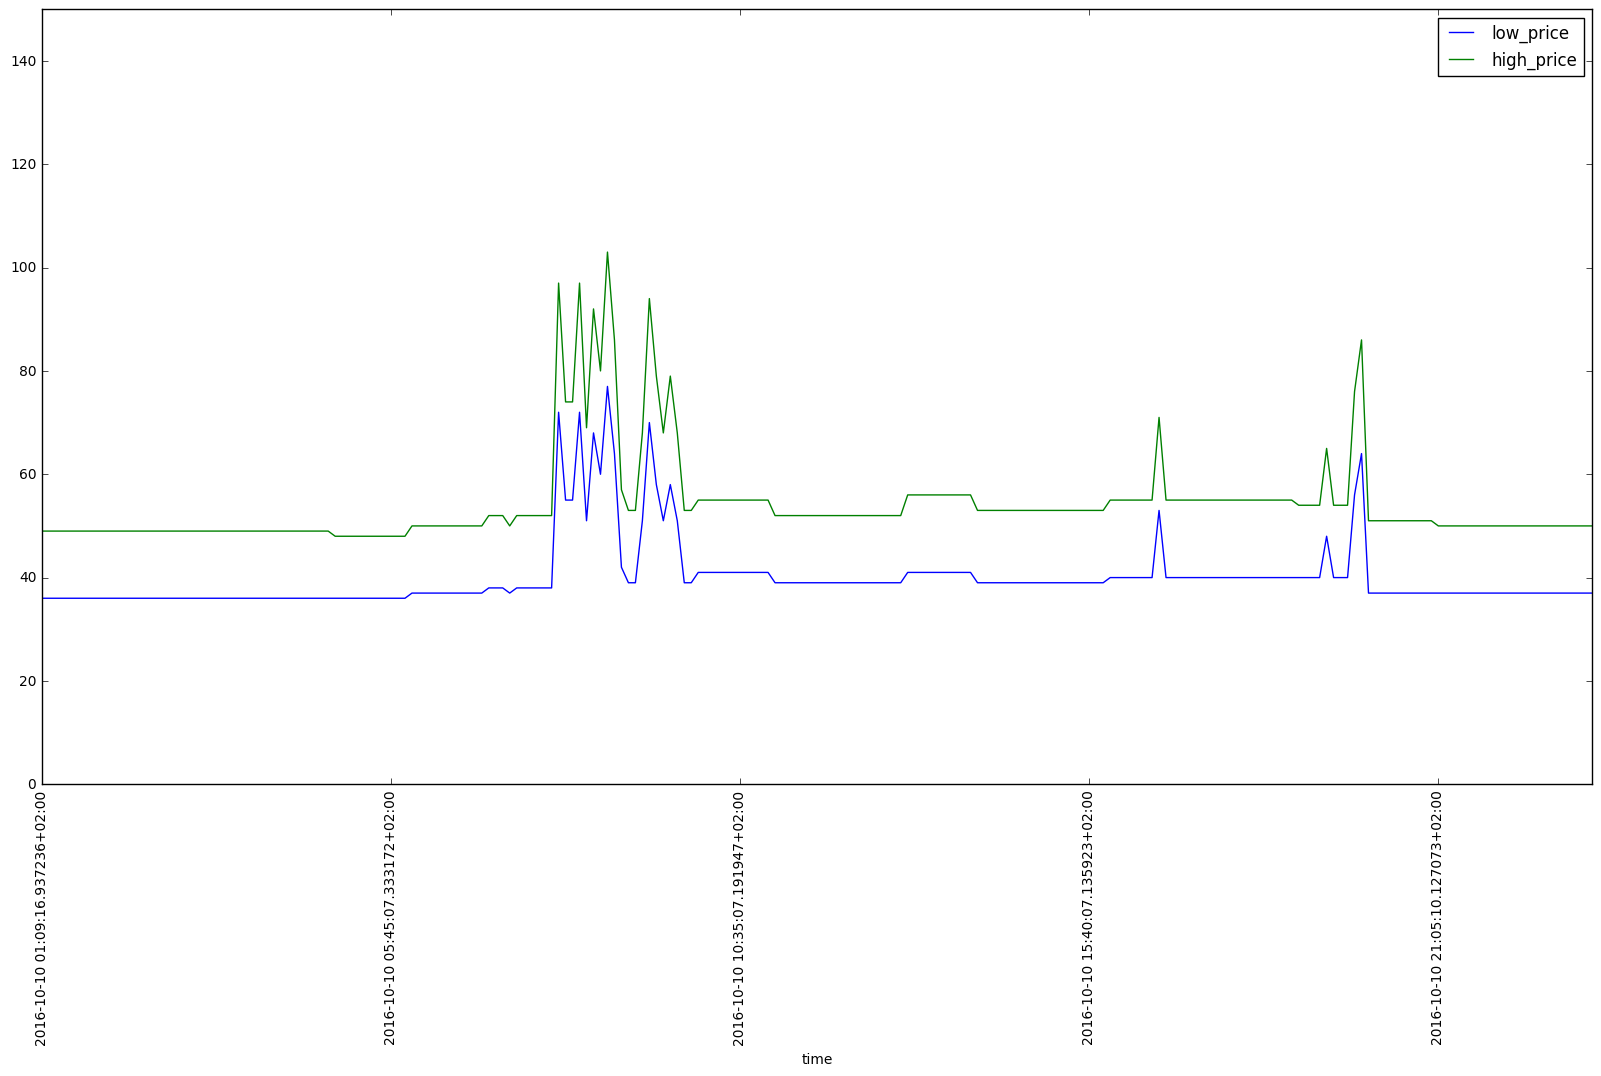

In [99]:
filtered_df
ax = filtered_df.plot(x='time', y=['low_price', 'high_price'], figsize=(20, 10), rot=90)
ax.set_ylim(0, 150)

In [88]:
pd.to_datetime(filtered_df['time']).dt
